In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from src.data.make_dataset import *
from src.data.modal_data import *

import catboost
from catboost import CatBoostClassifier, CatBoostRegressor

import shap

shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
loc = 'nw2'
turbine = 'c02'
mode = 'ss2'

# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
data_folder = os.path.join(package_folder, 'data')
selected_data= pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_' + mode + '_selected_data_large.csv'))
selected_data['timestamp'] = pd.to_datetime(selected_data['timestamp'])
selected_data = selected_data.set_index('timestamp')

from src.data.utils import get_input_data
from src.data.harmonics import *

data = get_input_data(data_folder, loc, turbine)
harmonics_data = harmonics(data['turbine_data'].filter(regex='rpm'), [1,3,6, 9])

selected_columns = ['mean_NW2_C02_rpm', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed', 'sin_mean_NW2_C02_yaw',
       'cos_mean_NW2_C02_yaw', 'sin_mean_NW2_C02_winddirection',
       'cos_mean_NW2_C02_winddirection',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature'
       ]

from src.data.make_dataset import create_input_data
mpe_ss_data = get_mpe_data(data['turbine_data'], 'SS', loc, turbine)

X = create_input_data(data_folder, loc, turbine)
X = X[selected_columns].loc[:datetime.datetime(2023, 6, 1, tzinfo=datetime.timezone.utc)]
y_train = selected_data['mean_frequency']

common_indices = X.dropna().index.intersection(y_train.dropna().index)
y_train = y_train.loc[common_indices]
X_train = pd.DataFrame(index = y_train.index)
for column in selected_columns:
    X_train[column] = X[column].loc[common_indices]

dropped mvbc columns:  {'mvbc_WandelaarMeasuringpile_Relative_humidity', 'mvbc_WandelaarBuoy_Sea_water_temperature'}


In [4]:
import pickle

models_folder = os.path.join(package_folder, 'models', loc)
model_path = os.path.join(models_folder, turbine, mode, 'catboost_model_large.pkl')
with open(model_path, 'rb') as file:
    regr_model = pickle.load(file)

In [5]:
regr_model.feature_importances_

array([ 1.24548244,  6.00061671,  9.97839118, 11.00380202,  4.55366923,
        6.27851497,  6.23132711,  5.56817303,  7.63184125,  8.47744769,
       19.4754966 ,  6.17253467,  7.38270309])

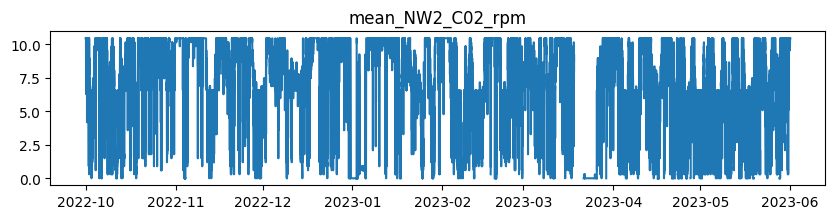

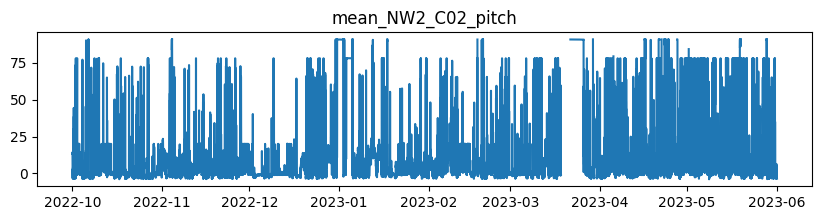

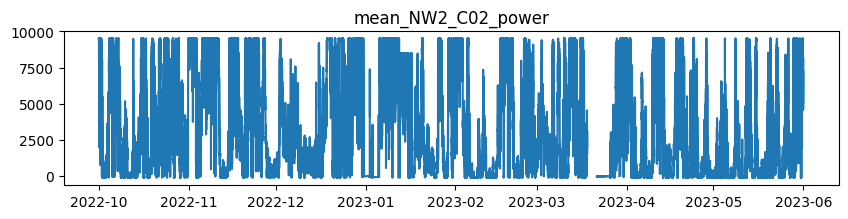

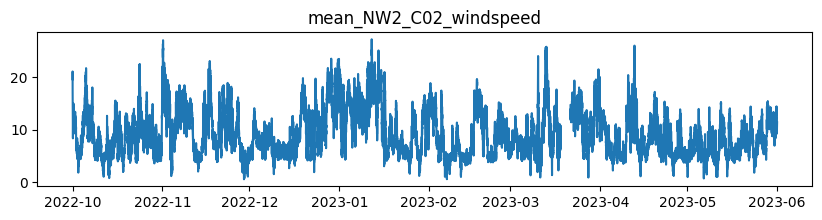

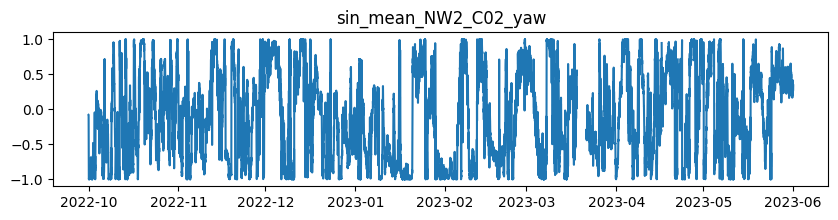

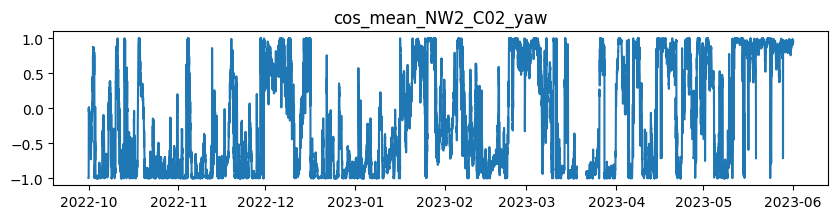

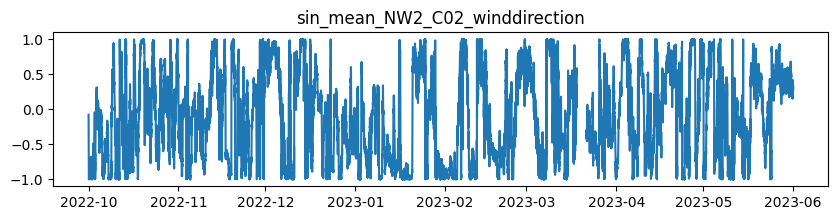

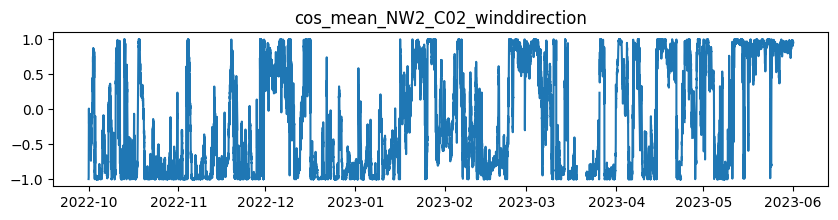

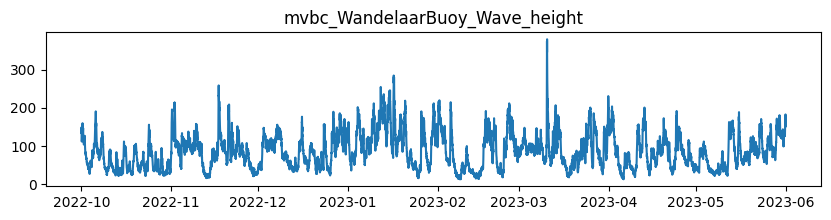

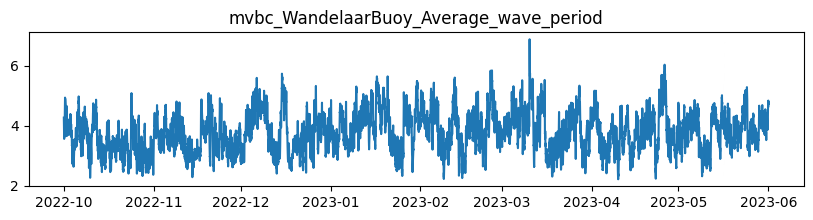

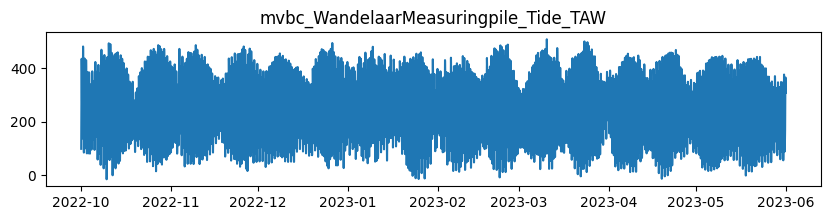

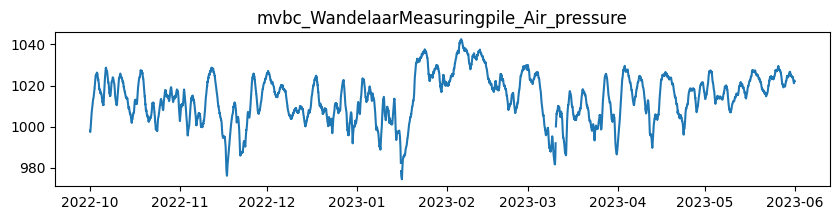

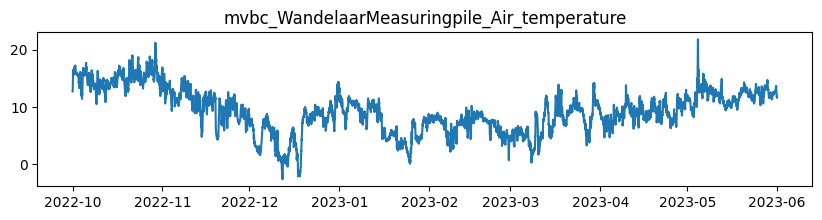

In [6]:
for col in X.columns:
    plt.figure(figsize=(10, 2))
    plt.title(col)
    plt.plot(X[col])
    plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


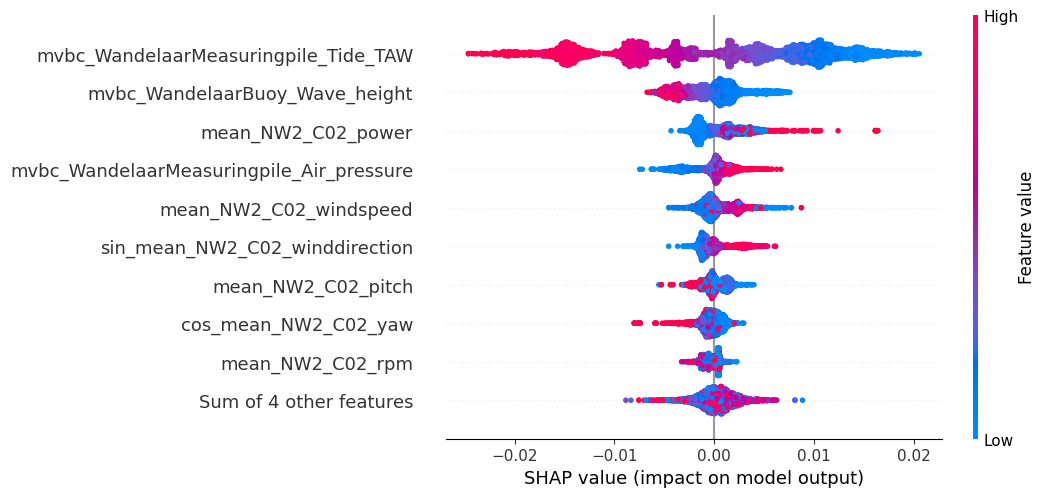

In [7]:
import shap

# Assuming regr_model is your trained multi-output model
# and X is your dataset
explainer = shap.TreeExplainer(regr_model)
shap_values = explainer.shap_values(X_train)

# Get SHAP values for the first output
first_output_shap_values = shap_values[0]

# Create an Explanation object from the SHAP values
# and the feature names (if available)
expl = shap.Explanation(values=first_output_shap_values, data=X_train)

# Now visualize the SHAP values for the first output
shap.plots.beeswarm(expl)


In [8]:
first_output_shap_values.shape

(4283, 13)

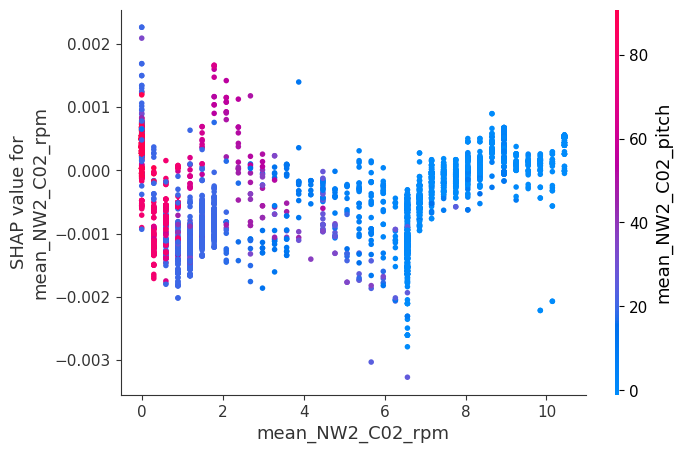

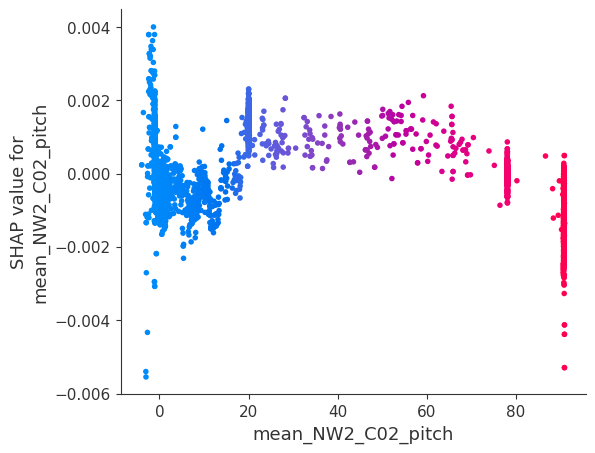

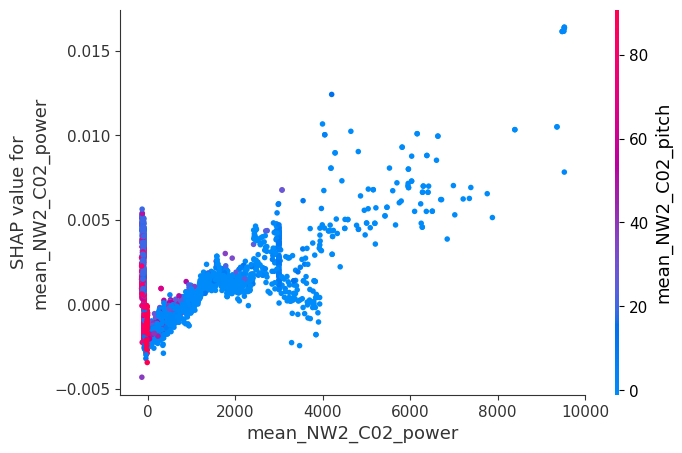

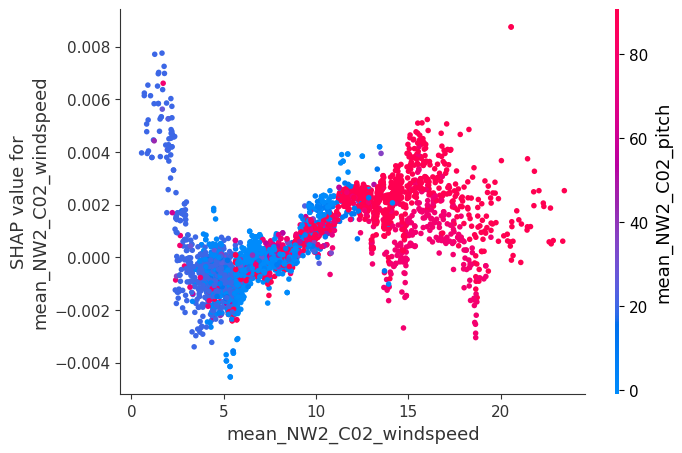

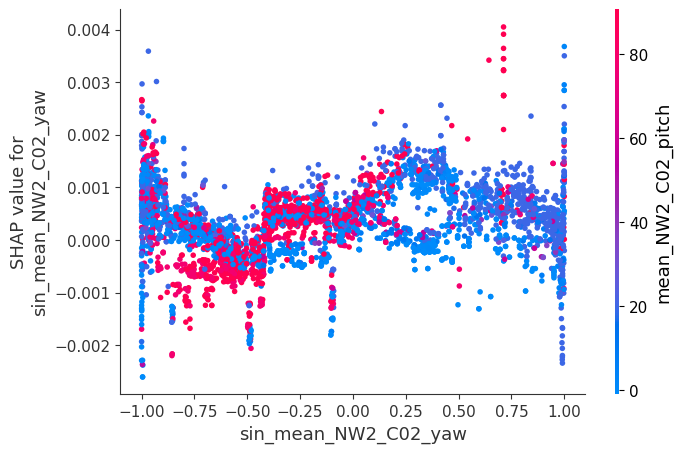

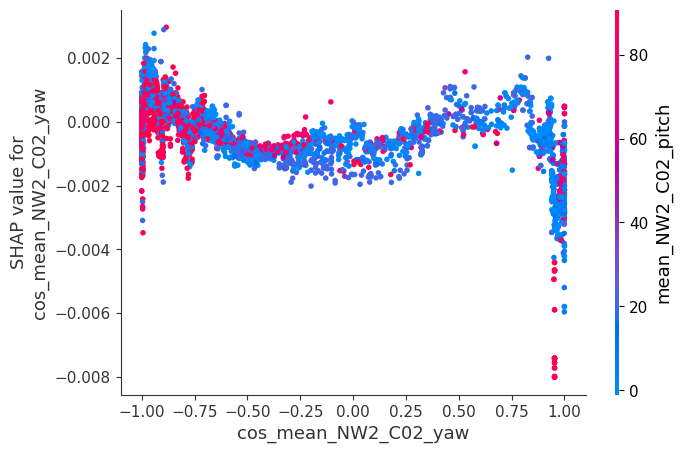

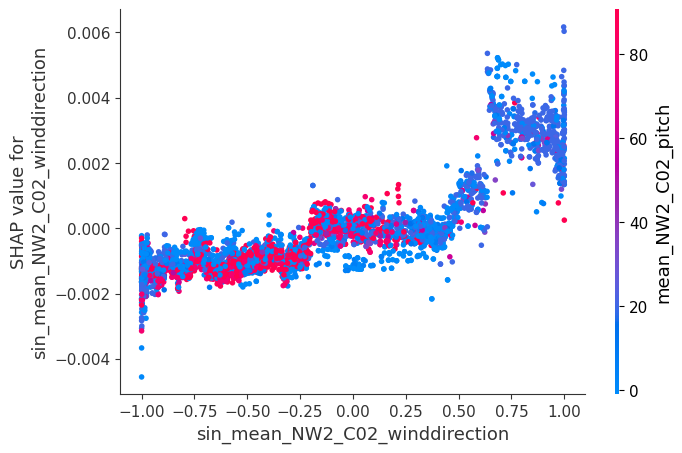

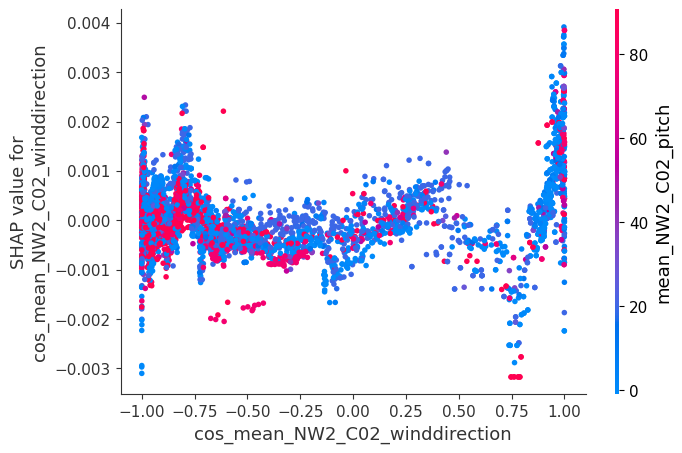

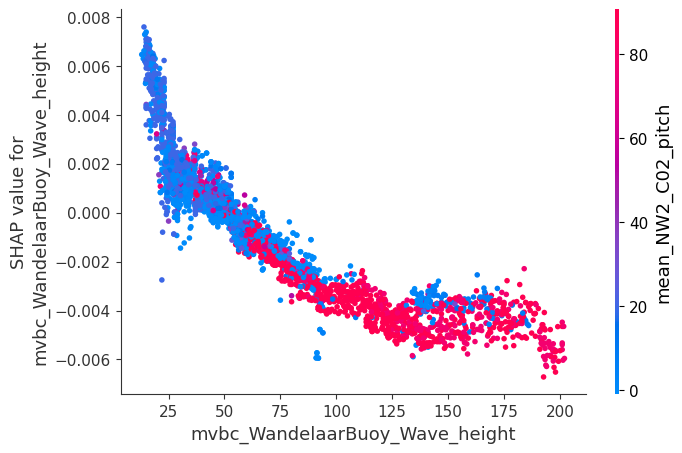

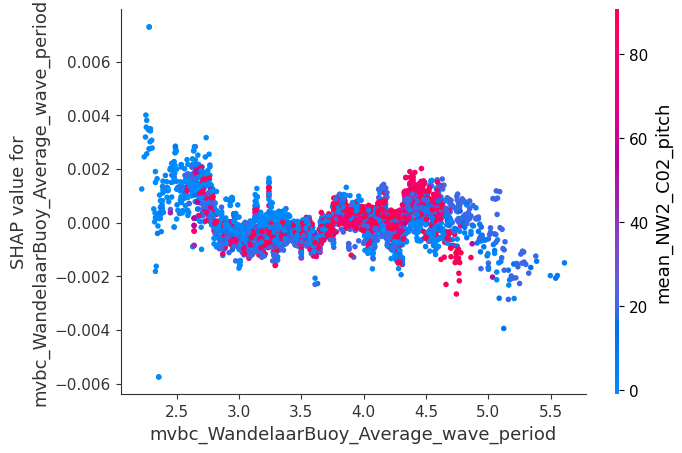

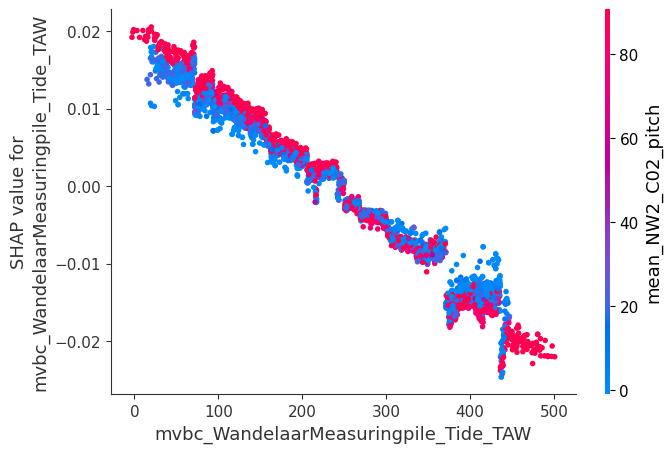

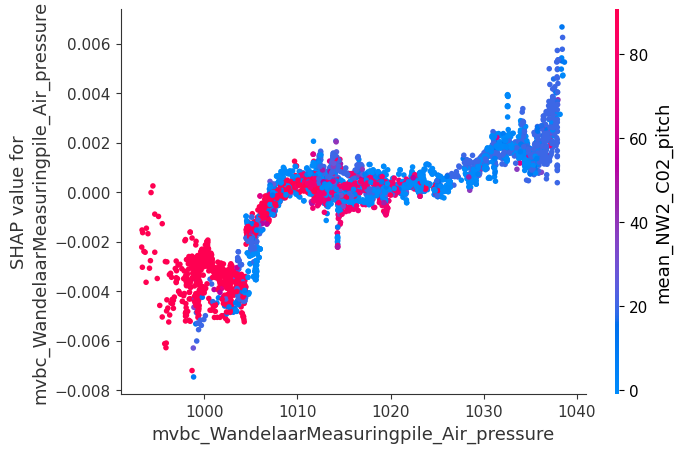

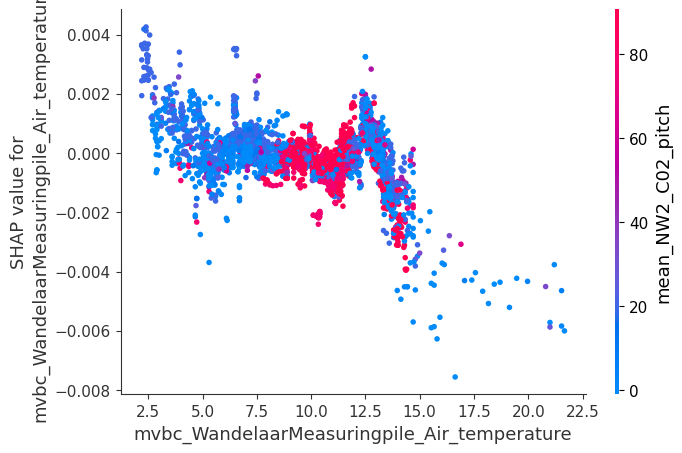

In [9]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
for col in X.columns:
    shap.dependence_plot(col, first_output_shap_values, X_train, interaction_index="mean_NW2_C02_pitch")

In [10]:
explainer = shap.Explainer(regr_model.virtual_ensembles_predict, X)

In [11]:
shap_values = explainer(X_train)

Permutation explainer: 4284it [31:45,  2.24it/s]                          


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


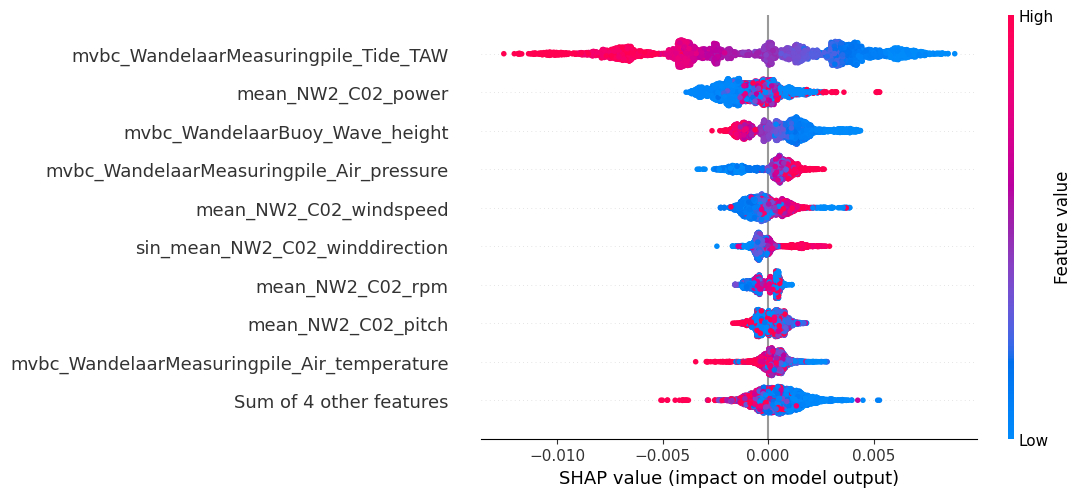

In [12]:
# and the feature names (if available)
explanations_ = shap.Explanation(values=shap_values.values[:,:,1], data=X_train)

# Now visualize the SHAP values for the first output
shap.plots.beeswarm(explanations_)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


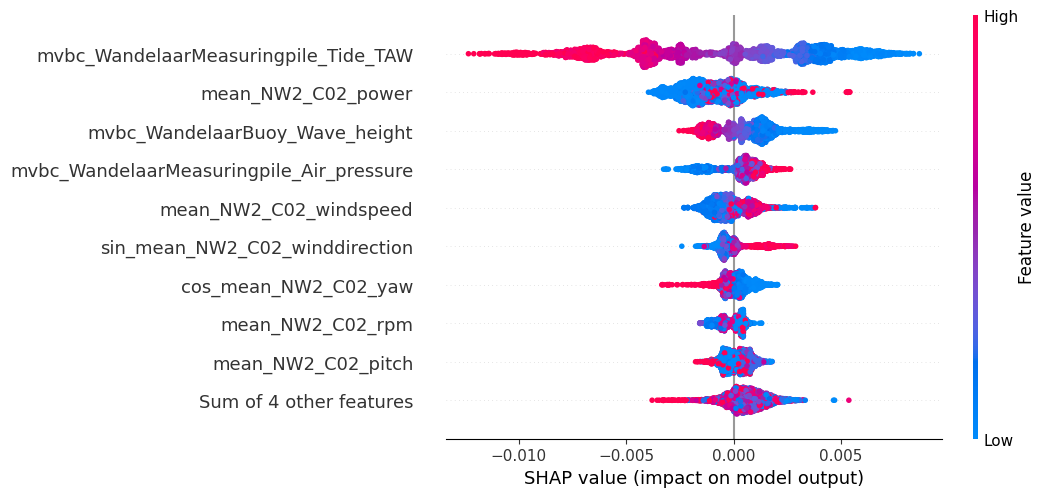

In [13]:
# and the feature names (if available)
explanations_ = shap.Explanation(values=shap_values.values[:,:,3], data=X_train)

# Now visualize the SHAP values for the first output
shap.plots.beeswarm(explanations_)

In [14]:
def custom_predict_function(X):
    return regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty')

explainer_virtual = shap.Explainer(custom_predict_function, X)
shap_values_virtual = explainer_virtual(X)

Permutation explainer: 34969it [2:11:37,  4.42it/s]                              


IndexError: index 10892 is out of bounds for axis 0 with size 4283

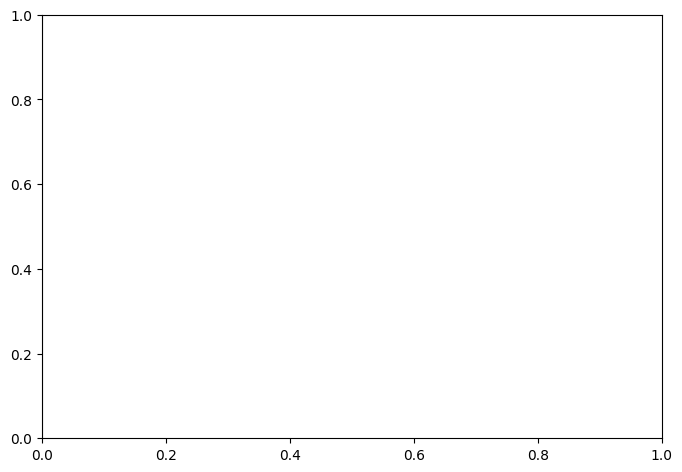

In [15]:
knowledge_uncertainty_shap = shap_values_virtual.values[:,:,1]
# and the feature names (if available)
explanations_virtual = shap.Explanation(values=knowledge_uncertainty_shap, data=X_train)

# Now visualize the SHAP values for the first output
shap.plots.beeswarm(explanations_virtual)


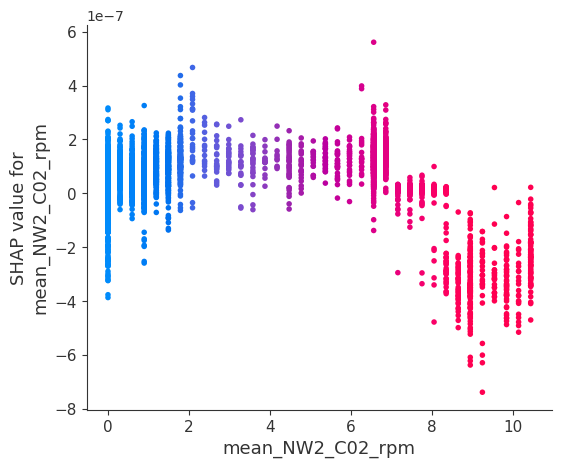

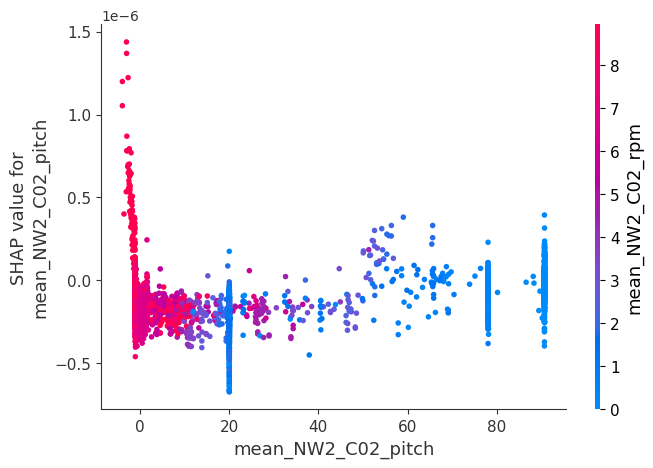

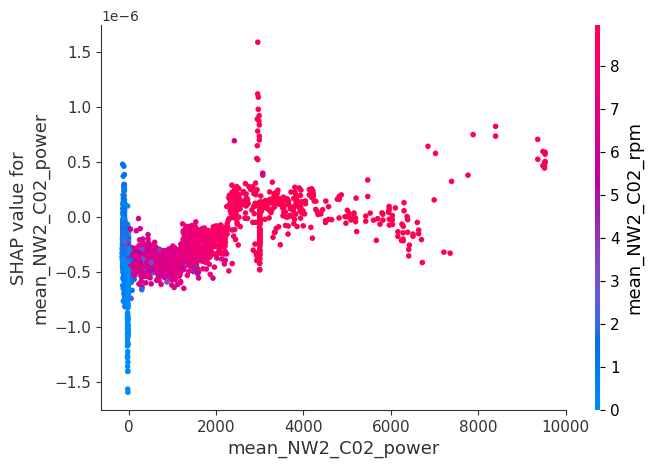

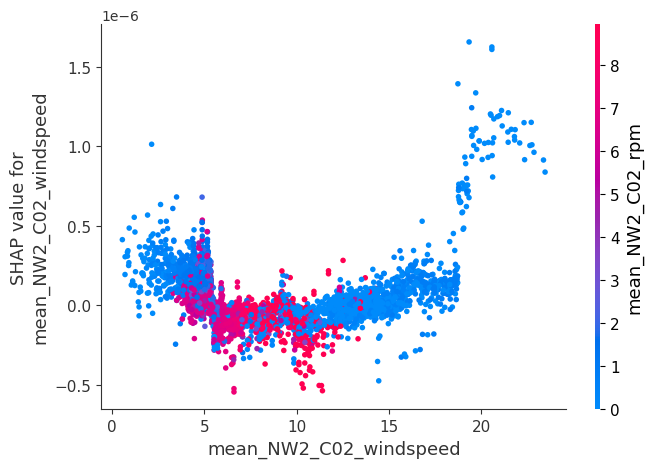

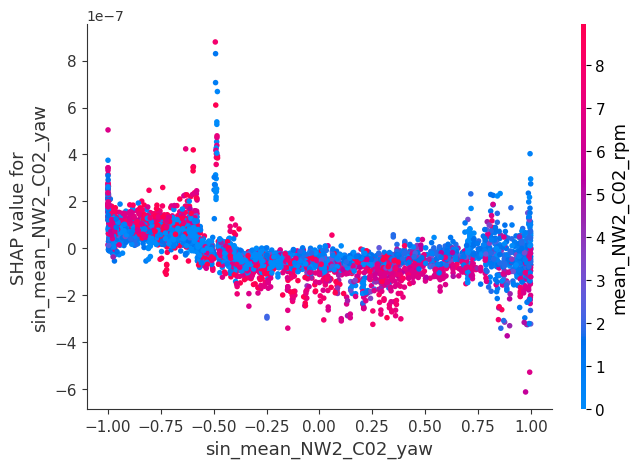

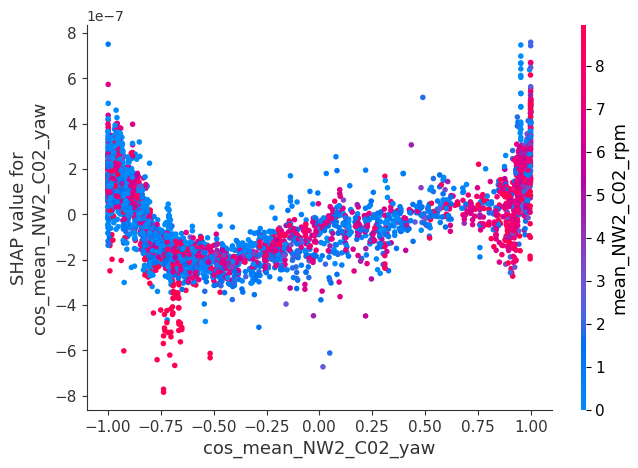

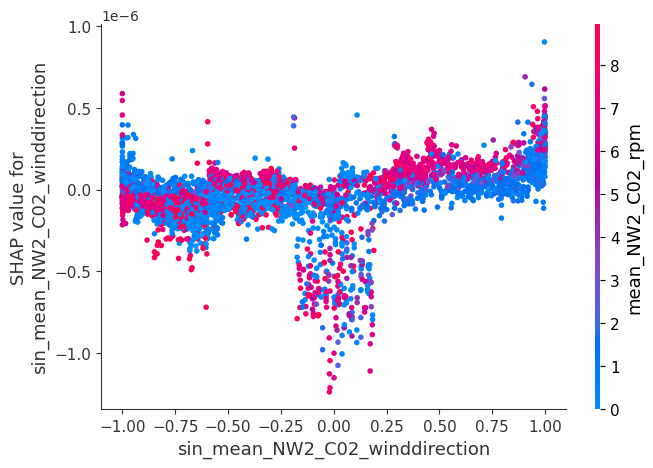

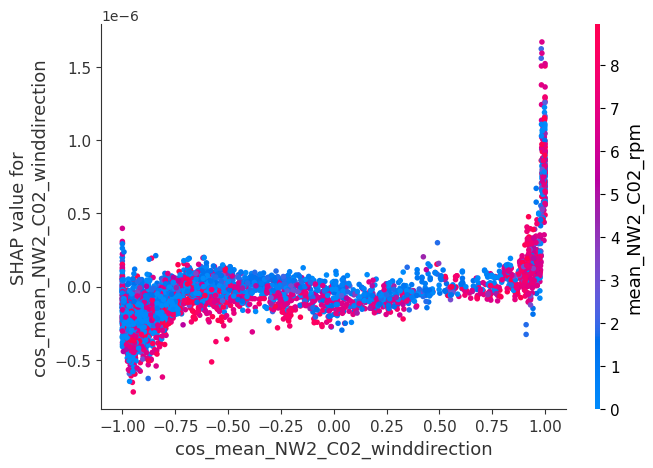

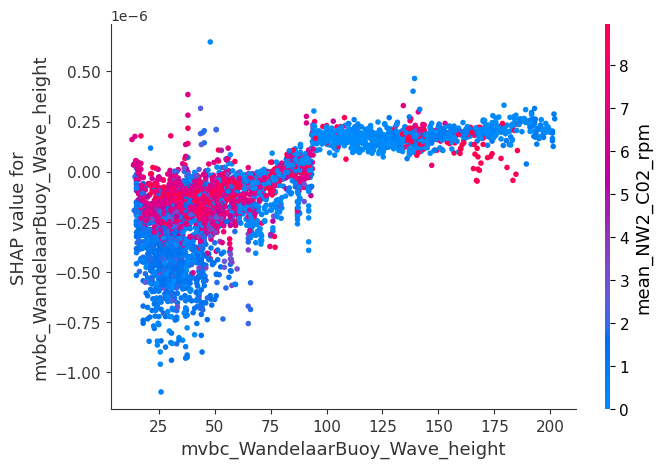

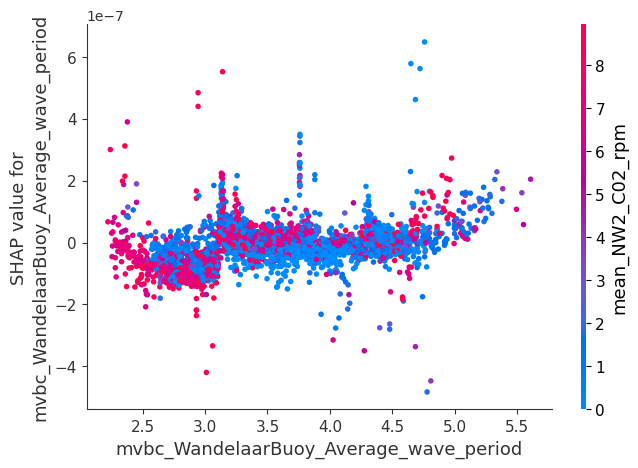

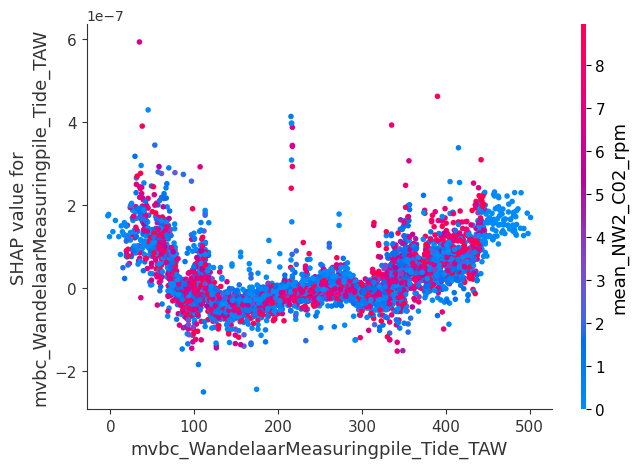

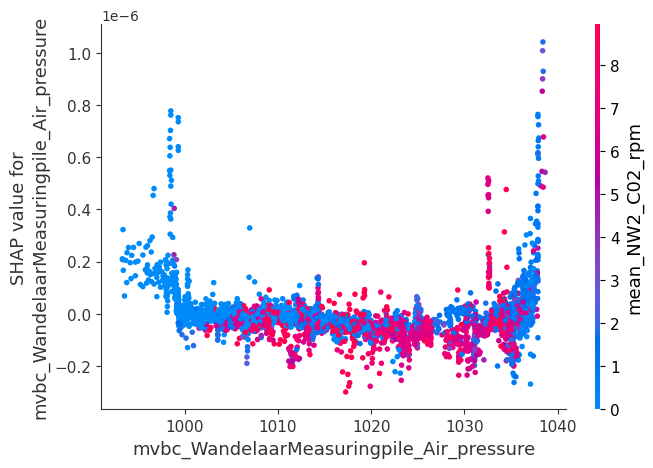

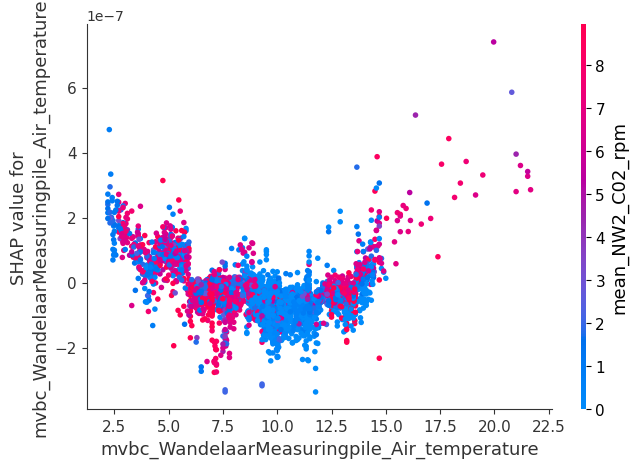

In [ ]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
for col in X.columns:
    shap.dependence_plot(col, knowledge_uncertainty_shap, X, interaction_index="mean_NW2_C02_rpm")

In [ ]:
X_train.shape

(4283, 13)

In [ ]:
shap_values.values[:,:,3]

array([[ 0.00035803,  0.00070631, -0.00284306, ..., -0.00418484,
        -0.00171302, -0.00054495],
       [ 0.0004144 ,  0.00069341, -0.00251091, ..., -0.0033292 ,
        -0.00171983, -0.00080952],
       [ 0.00031017,  0.00057648, -0.00244704, ..., -0.00287918,
        -0.00170705, -0.00034489],
       ...,
       [-0.00064381,  0.00058207, -0.00062232, ...,  0.00084892,
         0.00105606,  0.0003683 ],
       [-0.00057922,  0.00068017, -0.00085439, ...,  0.00145158,
         0.00101703,  0.00028994],
       [-0.0001185 ,  0.0006527 , -0.00081828, ...,  0.00192947,
         0.00102996,  0.0002002 ]])

In [ ]:
shap_values.values[:,:,19]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])